# COMP30810 - Intro to Text Analytics
## Group 4: Homework 2 
#### Group name: Cessna Skyhawk
#### Team members: Lucy Byrne, Fiachra Dunn, Órlaith Joyce, Michael Jordan, Eimear O'Shea Breen

# Introduction

For this assignment we are learning the classification model for "trainingset.csv" which contains 1557 news articles from 5 different categories: ['business', 'entertainment', 'politics', 'sport', 'tech']. The aim is to apply the learned model to get the predicted labels for "testdata.csv", a dataset of unlabeled articles.

* **In part 1**, we clean the given raw training data and represent the cleaned words as nltk tokens.
* **In part 2**, we perform an analysis on the training data to uncover insights about it's meaning and patterns.
* **In part 3**, we convert our clean data into numerical representation vectors and explore multiple options for this.
* **In part 4**, we analyze multiple models and combinations of vectors and classifiers to find the best fit for this dataset.
* **In part 5**, we label the given test data with the predicted categories from our chosen model.

In [1]:
#Import relevant libraries
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
import pandas as pd
import scikitplot as skplt
import string
import time 
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn import metrics
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from wordcloud import WordCloud

# Part 1: From Raw Data to Clean Representation of Documents

In this section we will load and clean the raw csv file.

## Load Training Dataset

Here, we load the training set file. We also used the seperator delimiter to create a category column allowing us to to see which category each article falls into. 

In [2]:
raw_trainset = pd.read_csv('trainingset.csv',sep='^',header=0) 
raw_trainset.head()

,content,category
0,French boss to leave EADS The French co-head o...,business
1,"Gamers could drive high-definition TV, films, ...",tech
2,Stalemate in pension strike talks Talks aimed ...,politics
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment
4,Tautou 'to star in Da Vinci film' French actre...,entertainment


## Check for Missing Data
Reasons to check this:
* We can be sure the training set file loaded and seperated correctly
* The original file may have missing data

In [3]:
if((len(raw_trainset[raw_trainset['content'] == None])) > 0):
    print("Content Missing:")
    print(raw_trainset[raw_trainset['content'] == None])
else:
    print("All content present")

if((len(raw_trainset[raw_trainset['category'] == None])) > 0):
    print("Category Data Missing:")
    print(raw_trainset[raw_trainset['category'] == None])
else:
    print("All categories present")

All content present
All categories present


There are no fields missing, so do not have to perform any additional steps here.

## Check for Outlier Categories
The outline of the questions states that there should only be 5 categories; bsuiness, entertainment, politics, sport and tech. This section will check if there are any categories that should not be in our dataset.

In [4]:
print(raw_trainset.groupby("category").size())

category
business         356
entertainment    266
politics         292
sport            361
tech             282
dtype: int64


There are only 5 categories here and no outliers, so we di not need to perform any additional steps.

## Remove Duplicates
It is important to eliminate duplicates so as not to skew the result of the analysis. We are going to check 2 things here:
* Are there duplicate articles?
* Are there duplicate articles that are labelled with different categories?

If there are conflicting labels, it will confuse the classifier.

In [5]:
 #check if any of the articles are the same
raw_trainset['duplicateContent'] = raw_trainset.duplicated(subset='content', keep=False)
 #check if there are ROWS the same - ie the article AND category on a row matches another row
raw_trainset['duplicateRow'] = raw_trainset.duplicated(subset=None, keep=False)

# If the num duplicate rows = num duplicate categories, i.e no conflicting data 
#(no articles that are listed twice have different categories) 
if(len(raw_trainset[raw_trainset['duplicateRow'] == True]) == len(raw_trainset[raw_trainset['duplicateContent'] == True])):
    print("Category is the same for duplicate content (no conflicting data)")
else:
    print("Conflicting Data")
    
#make a new training set
new_trainset = raw_trainset.drop_duplicates(subset='content', keep='first', inplace=False).filter(['content', 'category'])

#show how many duplicates were removed
print("\nOld trainset length: " + str(len(raw_trainset)))
print("New trainset length: " + str(len(new_trainset)))

Category is the same for duplicate content (no conflicting data)

Old trainset length: 1557
New trainset length: 1510


* There were no duplicate articles found with different categories, thus no conflicting data.
* As you can see above duplicates were found as the old file contained 1557 articles but now there is 1510.

## Tokenization
Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens. In the process of tokenization, some characters like punctuation marks are discarded.

#### Make a list containing all the token lists for each document.

In [6]:
wordExp = r'\w+' # this pattern finds all the words
tokenizer = RegexpTokenizer(wordExp)

tokensList = [] # this is a list of lists. Each list contains the tokens of a document.

for content in new_trainset['content']:
    token_words = tokenizer.tokenize(content) #tokenize all words in the document
    tokensList.append(token_words) #add this list to tokensList

We now have a lists of lists, where each list contains the tokens for each article in order. Below shows what the list looks like.

In [7]:
print(tokensList[:2])

[['French', 'boss', 'to', 'leave', 'EADS', 'The', 'French', 'co', 'head', 'of', 'European', 'defence', 'and', 'aerospace', 'group', 'EADS', 'Philippe', 'Camus', 'is', 'to', 'leave', 'his', 'post', 'Mr', 'Camus', 'said', 'in', 'a', 'statement', 'that', 'he', 'has', 'accepted', 'the', 'invitation', 'to', 'return', 'full', 'time', 'to', 'the', 'Lagardere', 'group', 'which', 'owns', '30', 'of', 'EADS', 'I', 'will', 'give', 'up', 'my', 'role', 'as', 'soon', 'as', 'the', 'board', 'of', 'directors', 'asks', 'me', 'to', 'do', 'so', 'he', 'said', 'Airbus', 'head', 'Noel', 'Forgeard', 'is', 'now', 'set', 'to', 'replace', 'Mr', 'Camus', 'bringing', 'the', 'company', 's', 'power', 'struggle', 'to', 'an', 'end', 'Fighting', 'between', 'Mr', 'Camus', 'and', 'Mr', 'Forgeard', 'has', 'hit', 'the', 'headlines', 'in', 'France', 'and', 'analysts', 'feared', 'that', 'this', 'fighting', 'could', 'destabilise', 'the', 'defence', 'and', 'aerospace', 'group', 'French', 'finance', 'minister', 'Herve', 'Gaymard

### Decapitalization
* This function decapitalizes all words in token list.
* This step will only decapitalise words with capital letter at the beginning of the word.
* We do not depactialize words that are all capitals due to the importance of acronyms. For example, "US" (the country) should not be changed to "us" (group of people).

In [8]:
def decapitalise(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        
        decapitalised = [] #this will store a list of decapitalised tokens from a single doc
        for word in tokens: #for each word in the list
            if not word.isupper(): #don't decapitalise if the whole word is in uppercase anyway - avoids decapitalising acronyms like US, LA, ID 
                decapitalised.append(word.lower()) # change to lower case
            else:
                decapitalised.append(word)
        newTokenList.append(decapitalised) #add decapitalised list to overall list
        
    return newTokenList

### Stopwords
* This step removes stopwords from the token list to remove noise like "the", "a", etc.
* We got the stopwords list from the default nltk list

In [9]:
def remove_stopwords(list_of_tokenLists):
    stopword_list = stopwords.words('english') #impotr default nltk stopwords
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        notStop = [] #this will store a list of non-stopword tokens from a single doc
        for word in tokens: #for each word in the list
            if word not in stopword_list: #if word is not a stopword, append it
                notStop.append(word)
        newTokenList.append(notStop) #append newlist to the overall list
        
    return newTokenList

### Remove Numbers
* This removes numbers from the token list  
* Does not remove words that contain numbers eg. 2nd, 3g etc. Sometimes there'll be unusual tokens, for example, 0.04s ("0.04 seconds") may be changed to 004s and lose its meaning. However, we are confident that these few outliers won't negatively affect our overall accuracy.

In [10]:
def remove_numbers(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        
        noNumbers= [] #this will store a list of tokens from a single doc
        for word in tokens: #for each word in the list#
            if not word.isdigit():
                noNumbers.append(word) # remove number
        newTokenList.append(noNumbers)
        
    return newTokenList

###  Expand Contractions
* Contractions are shortened version of words or syllables. 
* Converting each contraction to its expanded, original form helps with text standardization.

In [11]:
#expandContractions
def expandContractions(inputList):
    contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": " what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    }
    #for every word in the input text
    for list_of_tokens in inputList:
        for word in list_of_tokens:
            # if the word is in our dictionary replace it with the expanded version.
            if (word.lower() in contractions):
                inputList = inputList.replace(word, contractions[word.lower()])
            #if the word contains a hyphen, we'll replace the hyphen with a space leaving two words
            if ("-" in word):
                inputList = inputList.replace(word, word.replace("-", " "))
    return (inputList)

### Punctuation
* This step removes puntuation from the list, eg.  " . , - ; "
* Removing punctuation should not be done before removing contractions as this will interfere with the process - contractions with hyphens and apostrophes won't be found.

In [12]:
def punctuation(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        
        depunctuated = [] #this will store a list of tokens from a single doc
        for word in tokens: #for each word in the list
            depunctuated.append(word.translate(string.punctuation)) # remove punctuation
        newTokenList.append(depunctuated)
    return newTokenList

### Lemmatization

This ensures all variants of words will be counted the same, e.g "cats" and "cat" will be counted together.

In [13]:
def lemmatize(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for tokens in list_of_tokenLists:
        tempLemmatized = []
        for word in tokens:
            tempLemmatized.append(wordnet_lemmatizer.lemmatize(word))
        newTokenList.append(tempLemmatized)
    return newTokenList

### Cleaning Tokens

This step will perform the cleaning function and show the difference between our old tokens and new tokens.

In [14]:
def clean(list_of_tokenLists):
    list_of_tokenLists = expandContractions(list_of_tokenLists) #expand contractions
    list_of_tokenLists = decapitalise(list_of_tokenLists) #decapitalise
    list_of_tokenLists = remove_stopwords(list_of_tokenLists) #remove stopwords
    list_of_tokenLists = punctuation(list_of_tokenLists) #remove punctuation
    list_of_tokenLists = remove_numbers(list_of_tokenLists) #remove numbers
    list_of_tokenLists = lemmatize(list_of_tokenLists)
    return list_of_tokenLists


print("Tokens Before: ")
print(tokensList[0][:50])
print("------------")

tokensList = clean(tokensList) # clean


print("Tokens After: ")
print(tokensList[0][:50])

Tokens Before: 
['French', 'boss', 'to', 'leave', 'EADS', 'The', 'French', 'co', 'head', 'of', 'European', 'defence', 'and', 'aerospace', 'group', 'EADS', 'Philippe', 'Camus', 'is', 'to', 'leave', 'his', 'post', 'Mr', 'Camus', 'said', 'in', 'a', 'statement', 'that', 'he', 'has', 'accepted', 'the', 'invitation', 'to', 'return', 'full', 'time', 'to', 'the', 'Lagardere', 'group', 'which', 'owns', '30', 'of', 'EADS', 'I', 'will']
------------
Tokens After: 
['french', 'bos', 'leave', 'EADS', 'french', 'co', 'head', 'european', 'defence', 'aerospace', 'group', 'EADS', 'philippe', 'camus', 'leave', 'post', 'mr', 'camus', 'said', 'statement', 'accepted', 'invitation', 'return', 'full', 'time', 'lagardere', 'group', 'owns', 'EADS', 'I', 'give', 'role', 'soon', 'board', 'director', 'asks', 'said', 'airbus', 'head', 'noel', 'forgeard', 'set', 'replace', 'mr', 'camus', 'bringing', 'company', 'power', 'struggle', 'end']


We see the cleaning function was successful, as both lists are different.

####  Add tokens column to our training set

In [15]:
new_trainset['tokens'] = tokensList
new_trainset.head()

,content,category,tokens
0,French boss to leave EADS The French co-head o...,business,"[french, bos, leave, EADS, french, co, head, e..."
1,"Gamers could drive high-definition TV, films, ...",tech,"[gamers, could, drive, high, definition, TV, f..."
2,Stalemate in pension strike talks Talks aimed ...,politics,"[stalemate, pension, strike, talk, talk, aimed..."
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[johnny, denise, lose, passport, johnny, vaugh..."
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[tautou, star, da, vinci, film, french, actres..."


####  Add joined tokens column to our training set

In [16]:
tokenContentList = []

for i in tokensList:
    tokenContentList.append(" ".join(i))

new_trainset['train_clean_content'] = tokenContentList
new_trainset.head()

,content,category,tokens,train_clean_content
0,French boss to leave EADS The French co-head o...,business,"[french, bos, leave, EADS, french, co, head, e...",french bos leave EADS french co head european ...
1,"Gamers could drive high-definition TV, films, ...",tech,"[gamers, could, drive, high, definition, TV, f...",gamers could drive high definition TV film gam...
2,Stalemate in pension strike talks Talks aimed ...,politics,"[stalemate, pension, strike, talk, talk, aimed...",stalemate pension strike talk talk aimed avert...
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[johnny, denise, lose, passport, johnny, vaugh...",johnny denise lose passport johnny vaughan den...
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[tautou, star, da, vinci, film, french, actres...",tautou star da vinci film french actress audre...


# Part 2: Analysis of Data

In this section we will investigate our clean dataframe, and perform tokenization on the data.

## Overview of Articles and Categories
This section will help us understand our dataframe at a high level.

### Overview of Categories

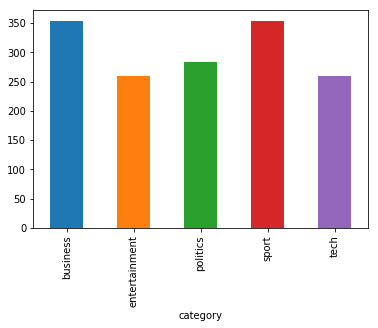

In [17]:
new_trainset.groupby("category").size().plot(kind='bar')

This chart shows how many articles of each category we have in our training set. It is quite a balanced dataset, but we have more sport and business examples than entertainment examples.

### Overview of content for each category

Here, we will see the average length of content for each category.

In [18]:
wordDict = {} #this will be used to plot the results later

catGroups = new_trainset.groupby('category') #group by category
groupsList = catGroups.groups.keys() #get names of categories in list form

for group in groupsList: #for each category name
    df = new_trainset[new_trainset['category'] == group] #slice the dataframe to get only this category
    length_group = len(df) #length of this category for calculation
    total_words = 0 #reset word value
    for content in df['content']: #get 1 article from this category
        words = content.split() #split into individual words
        total_words = total_words + len(words) #add number of words to master list
    wordDict[group] = total_words/length_group #record the average length in the dict
    print("Average words in " + str(group) + " articles : " + str(total_words/length_group)) #print the result

Average words in business articles : 339.05099150141643
Average words in entertainment articles : 329.35
Average words in politics articles : 460.65492957746477
Average words in sport articles : 336.31073446327684
Average words in tech articles : 507.6254826254826


#### Plot the results

This is a better way to vizualise the average length of each category's articles.

([<matplotlib.axis.XTick at 0x22ed48d10f0>,
 <a list of 5 Text xticklabel objects>)

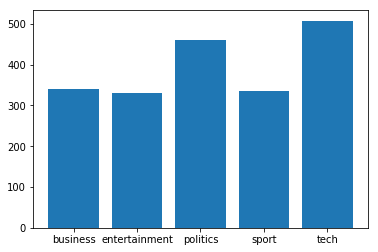

In [19]:
plt.bar(range(len(wordDict)), list(wordDict.values()), align='center') #make a bar chart
plt.xticks(range(len(wordDict)), list(wordDict.keys())) #assign labels

We can see from this chart that politics and tech articles tend to be the longest, so these categories will have the most content to learn from.

## Analysis of Corpus

Here, we will analyse our newly cleaned article content.

### Wordclouds

### Wordcloud of whole corpus

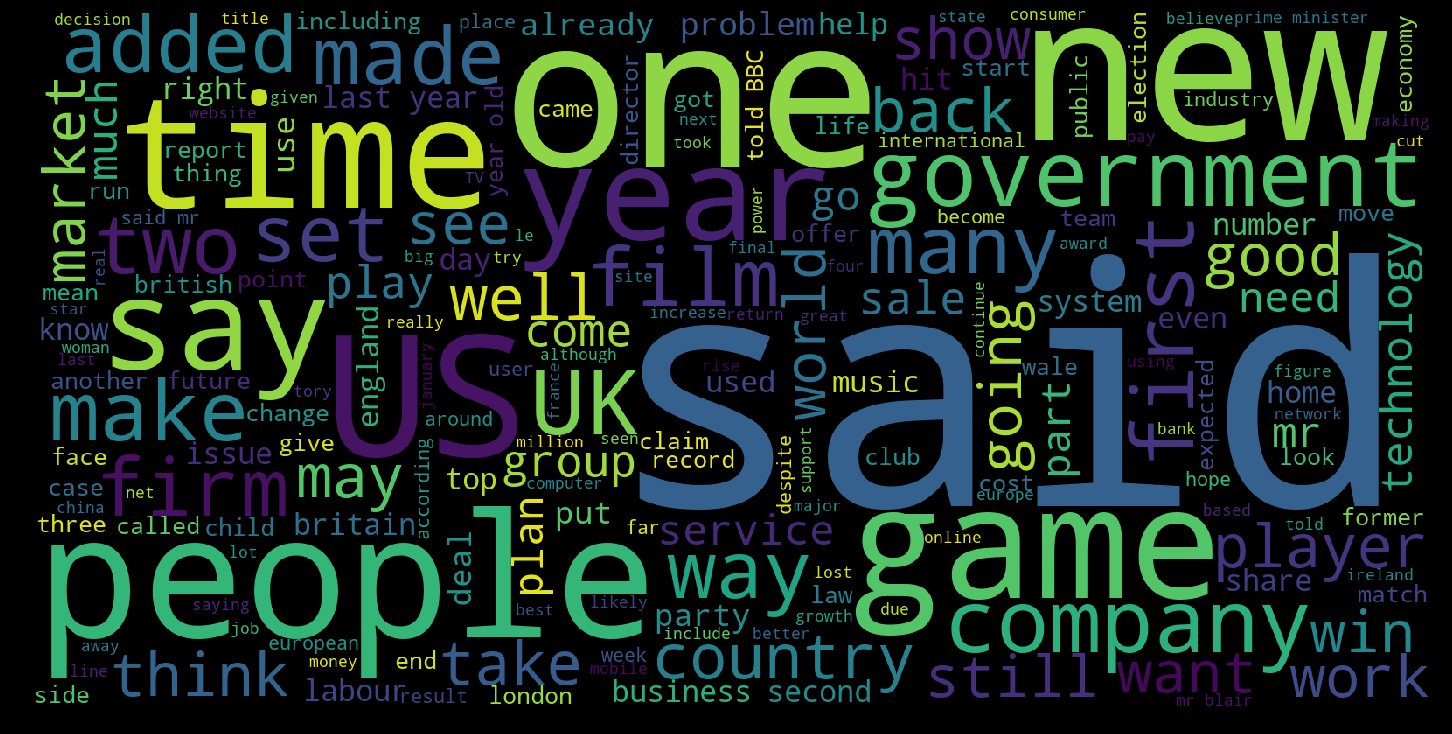

In [20]:
masterWordList = []

for content in new_trainset['train_clean_content']:
        masterWordList.append(content) #add each content to list

text = ' '.join(masterWordList) #join all of the corpus words

def wordcloud(words):
    wordcloud = WordCloud(width=1600, height=800).generate(text)
    plt.figure(figsize=(20,10), facecolor='k') #adjust size and color
    plt.imshow(wordcloud) #show wordcloud on plot
    plt.tight_layout(pad=0) #tight layout
    plt.axis("off") #dont show axis
    plt.show() #show visualisation
    
wordcloud(text)
#plt.savefig('img_wordcloud.png')

We can see in our word cloud that many different topics are represented in our corpus.  We see topics like 'technology' being mentioned by name,  'country' which probably refers to Politics, 'film' which most likely corresponds with Entertainment.

However we also see a lot of the most frequent words are probably ones used across all topics, such as 'said', 'people', 'one'.

### Wordcloud for each group

business:


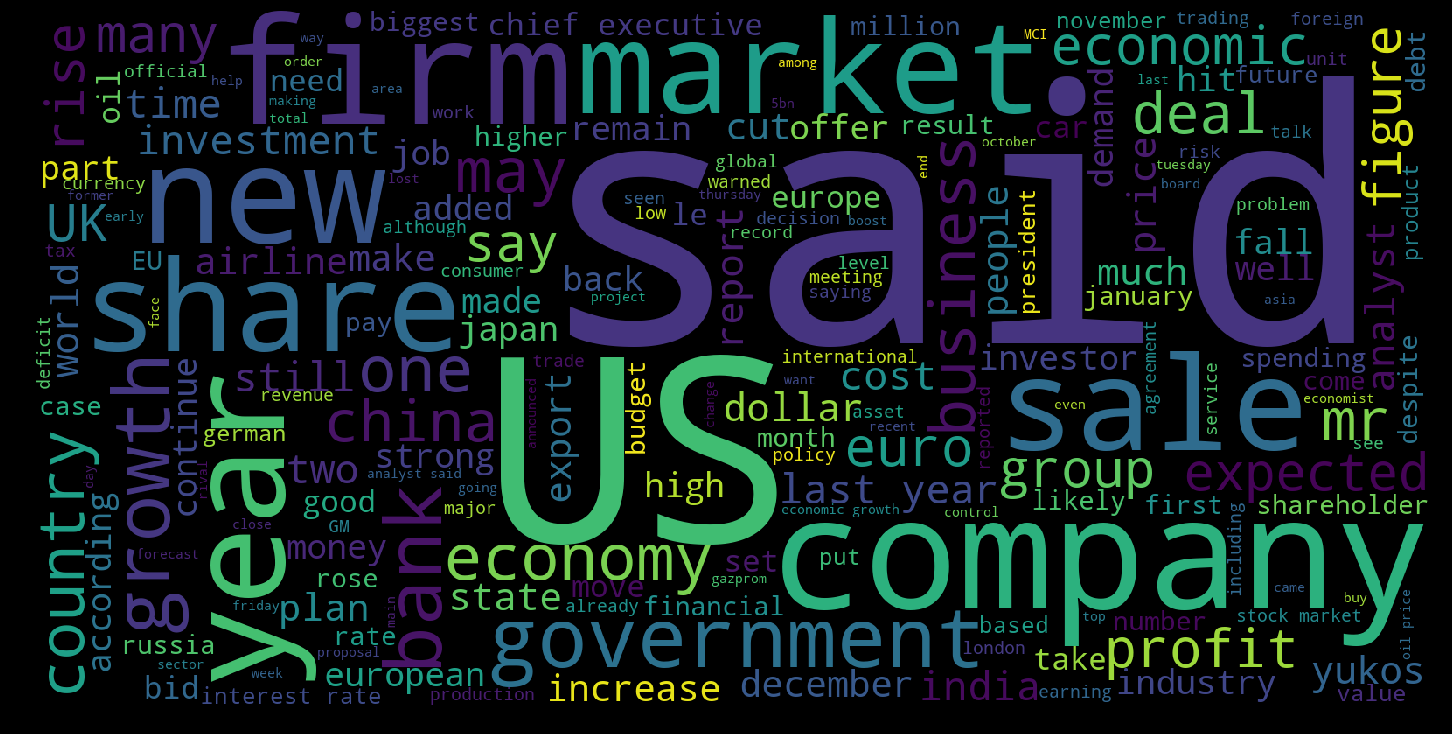

entertainment:


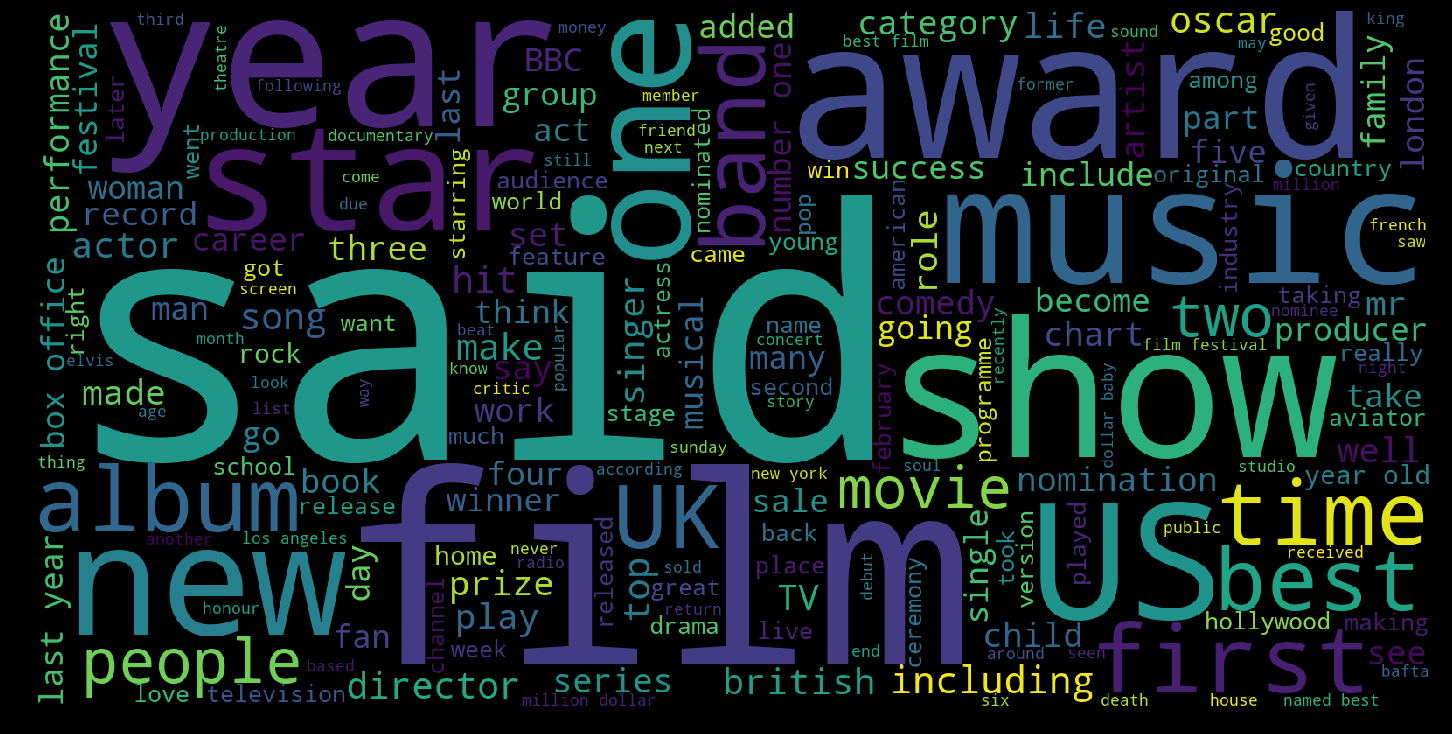

politics:


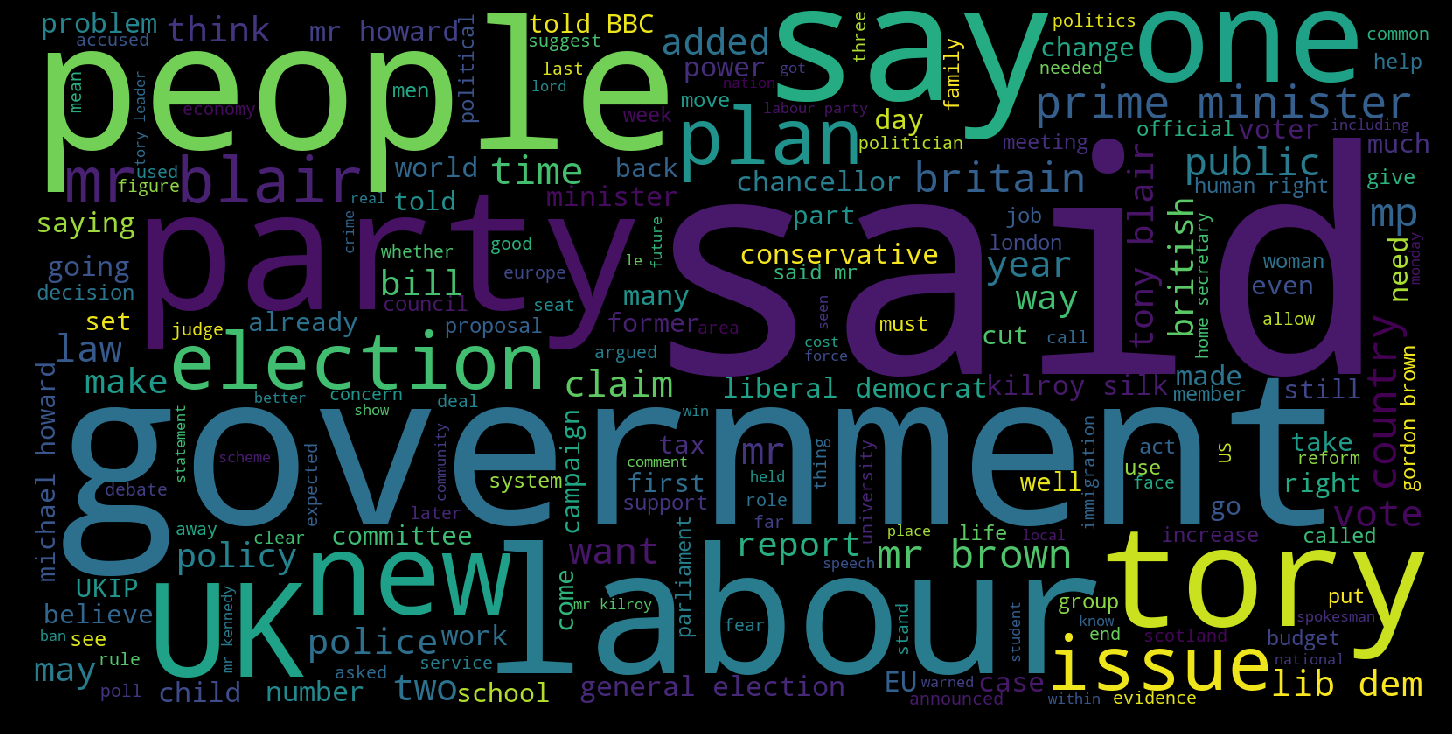

sport:


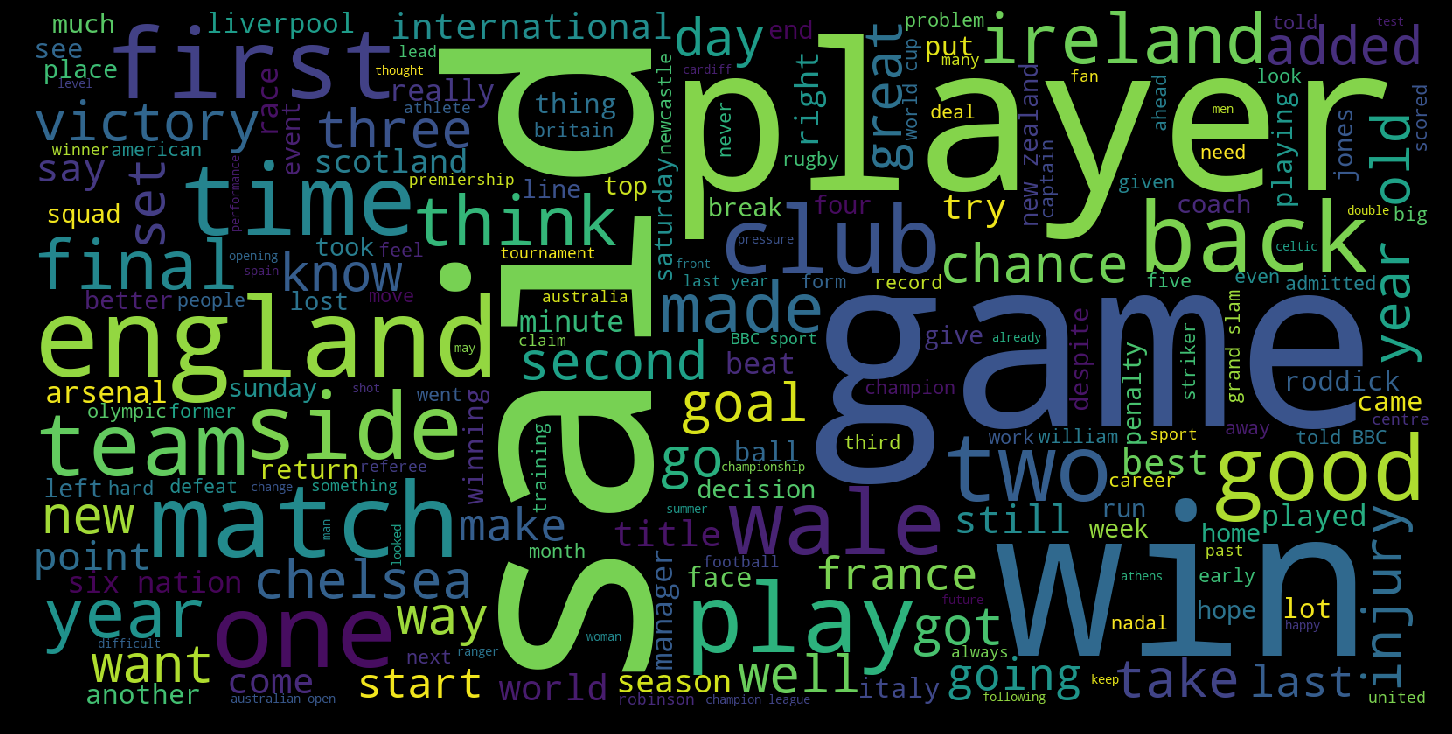

tech:


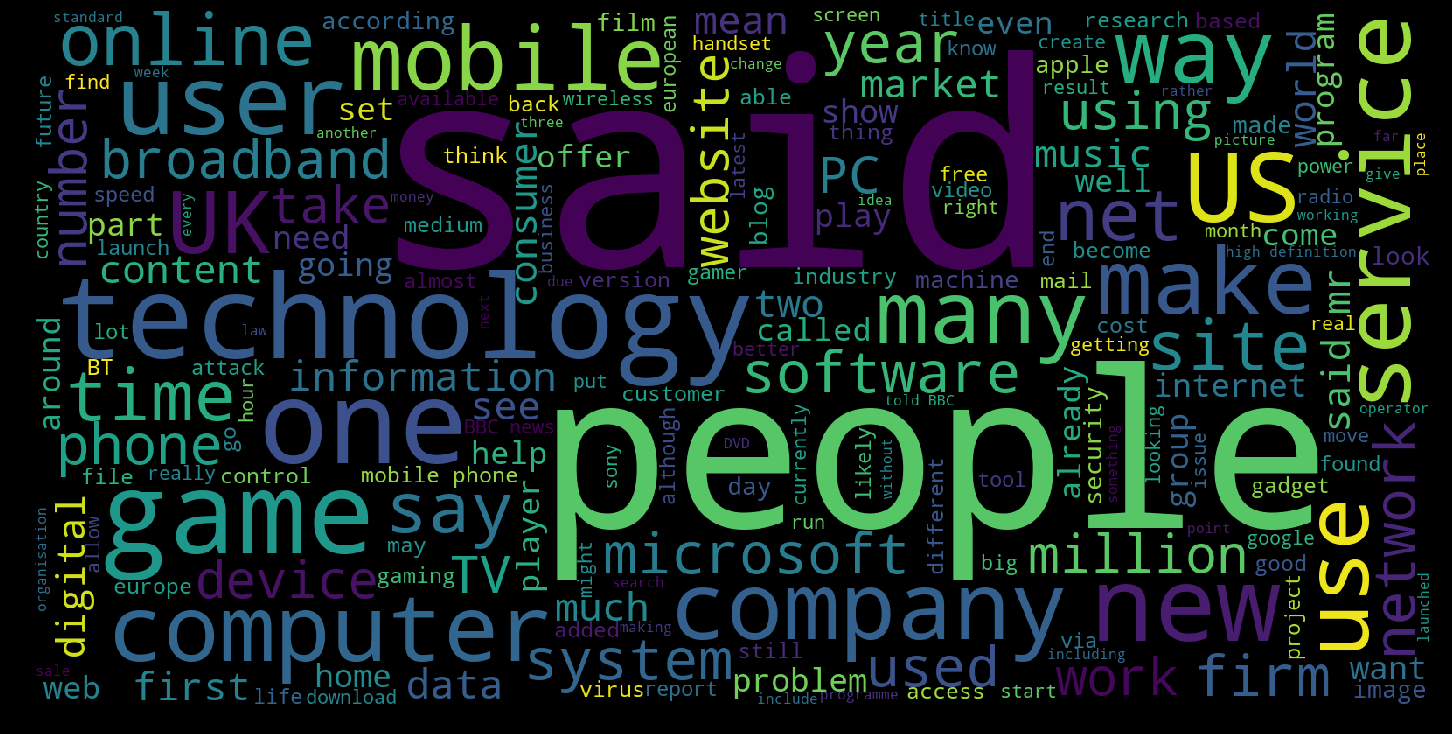

In [21]:
for group in groupsList: #for each category name
    df = new_trainset[new_trainset['category'] == group] #slice the dataframe to get only this category
    masterContentGroupList = []
    for content in df['train_clean_content']: #get 1 article from this category
        masterContentGroupList.append(content)
    text = ' '.join(masterContentGroupList) #join all of the group words
    print(str(group) + ":")
    wordcloud(text)

When we split wordclouds by document topic, a clear picture is painted of each topic.

In the intial wordcloud of the whole corpus, many of the most frequent words did not seem to be topic specific. However, in the case of individual classes a lot of the top words seem much more domain specific. (Although 'said' seems to be a frequent word in any topic.) It would be a very simple task for a person to identify which topics these wordclouds belong to without prior knowledge of our data.

## Most common words

### Most common words in corpus

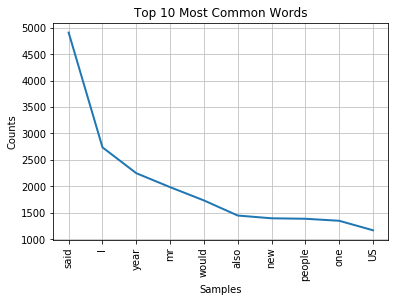

In [22]:
text = ' '.join(masterWordList)
words = text.split()
word_frequency = nltk.FreqDist(words)
word_frequency.plot(10, title = 'Top 10 Most Common Words')

Looking at the most 10 most common words in our corpus, it wouldn't be immediately obvious what sort of topics it might contain. This reflects what we saw in our previous wordclouds. The top words in the corpus tend to be those that are common to all articles and are not topic specific.

### Most common words by category

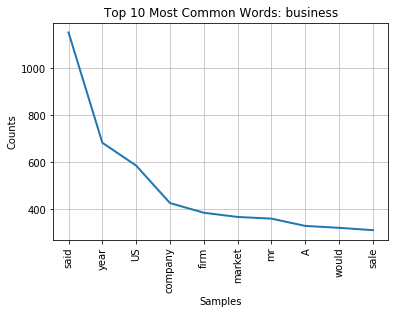

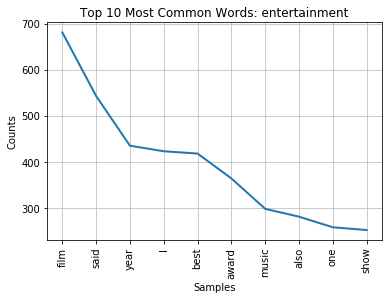

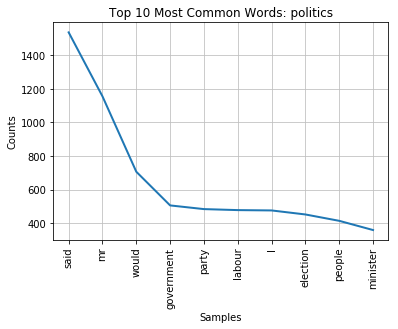

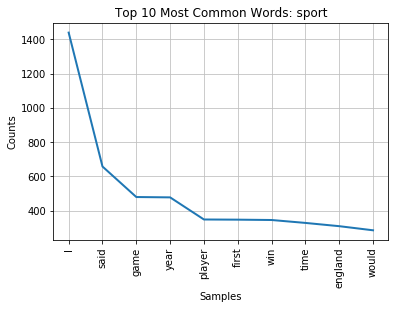

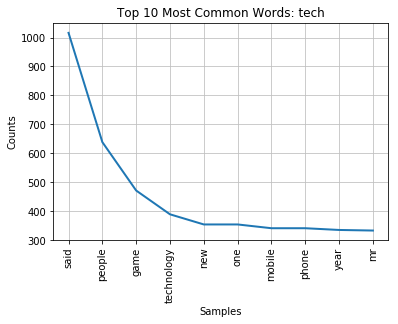

In [23]:
for group in groupsList: #for each category name
    df = new_trainset[new_trainset['category'] == group] #slice the dataframe to get only this category
    masterContentGroupList = []
    for content in df['train_clean_content']: #get 1 article from this category
        masterContentGroupList.append(content)
        
    text = ' '.join(masterContentGroupList) #join all of the group words
    words = text.split()
    word_frequency = nltk.FreqDist(words)
    title = 'Top 10 Most Common Words: ' + group
    word_frequency.plot(10, title = title)

When we consider the 10 most commond words by category, a different picture is revealed.

While we still see some of the words common across all topics, the top 10 words easily provide enough information to be classified by humans. There are clearly distinct, topic specific words occurring frequently for each class.

## Most common bigrams and trigrams for corpus

In [24]:
text = ' '.join(masterWordList)
words = text.split()

#bigrams
n = 2
bigrams = list(ngrams(words, n))
bigram_frequency = nltk.FreqDist(bigrams)

print("5-top most common bigram:")
for i in list(bigram_frequency.most_common(5)):
    print(i)
    
print("\n-------------\n")
    
#trigrams
n = 3
trigrams = list(ngrams(words, n))
trigram_frequency = nltk.FreqDist(trigrams)

print("5-top most common trigram:")
for i in list(trigram_frequency.most_common(5)):
    print(i)

5-top most common bigram:
(('last', 'year'), 317)
(('I', 'think'), 294)
(('told', 'BBC'), 240)
(('year', 'old'), 237)
(('said', 'mr'), 223)

-------------

5-top most common trigram:
(('told', 'BBC', 'news'), 93)
(('BBC', 'news', 'website'), 62)
(('mr', 'kilroy', 'silk'), 47)
(('told', 'BBC', 'radio'), 42)
(('leader', 'michael', 'howard'), 40)


In reviewing the most common bi-grams and tri-grams, we are once again shown some common non-top specific phrases such as 'last year', 'I think', 'told BBC'.

However we do see 'Leader Michael Howard', and 'Mr. Kilroy Silk' appear several times which are both in reference to British politicians. So it appears that politics may be more disproportianately represented by bi-grams and tri-grams.

## Most common nouns

#### Most common nouns for corpus
Below, we find all the noun tokens in the corpus and add it to the dataframe

In [25]:
nounList = []
for i in range(len(new_trainset)):
    tokens = new_trainset.iloc[i]['tokens']
    is_noun = lambda pos: pos[:2] == 'NN'
    nouns = [word for (word, pos) in nltk.pos_tag(tokens) if is_noun(pos)]
    nounList.append(nouns)
    
new_trainset['noun_tokens'] = nounList

Now, we investigate the most common nouns in the corpus.

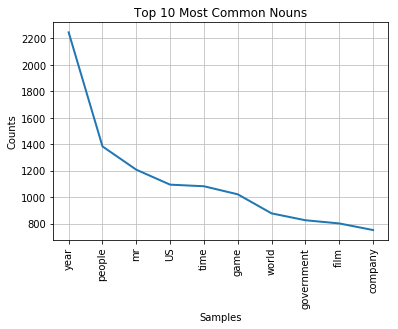

In [26]:
masterNouns = []
for noun_list in new_trainset['noun_tokens']:
    for noun in noun_list:
        masterNouns.append(noun)
        
word_frequency = nltk.FreqDist(masterNouns)
word_frequency.plot(10, title = 'Top 10 Most Common Nouns')

In viewing the top 10 nouns in our corpus. A clearer picture is painted of the topics that may be present than when we considered the top 10 words.

We see words such as 'game', 'government', 'film', 'company', which give some insight into what may be discussed in the articles.

#### Most common nouns for each category

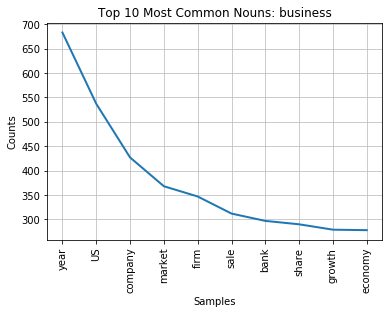

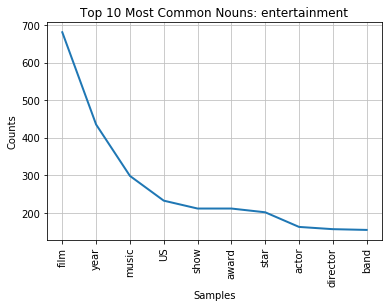

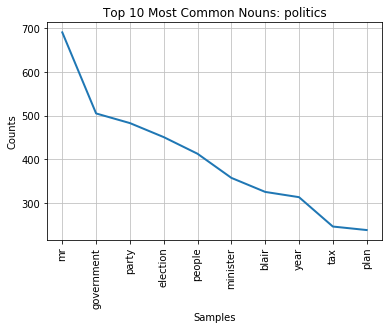

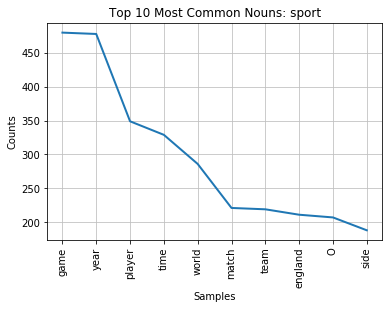

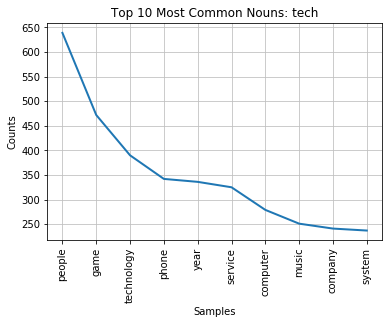

In [27]:
for group in groupsList: #for each category name
    df = new_trainset[new_trainset['category'] == group] #slice the dataframe to get only this category
    masterNounGroupList = []
    for content in df['noun_tokens']: #get 1 article from this category
        for noun in content:
            masterNounGroupList.append(noun)
        
    word_frequency = nltk.FreqDist(masterNounGroupList)
    title = 'Top 10 Most Common Nouns: ' + group
    word_frequency.plot(10, title = title)

Once again as we split our noun counts by topic, a unique picture is formed of each one. Each of the top 10 nouns for each topic seem more distinct from one another than when counting top 10 words.

### Final processing/cleaning step; converting categories to numerical values
As a final processing step after analysis, we will convert categories to numerical values for classification.

In [28]:
#print old headings for comparison
print(new_trainset['category'].head())
print("----------------------------")

#replace with new labels
labels = {"business": 0, "entertainment": 1, "politics": 2, "sport": 3, "tech": 4} #corresponding new values
new_trainset = new_trainset.replace(to_replace=labels, value=None)

#new labels
print(new_trainset['category'].head())

0         business
1             tech
2         politics
3    entertainment
4    entertainment
Name: category, dtype: object
----------------------------
0    0
1    4
2    2
3    1
4    1
Name: category, dtype: int64


# Part 3: From Clean Representation of Documents to Numerical Representation Vectors

This takes our newly constructed dataframe and converts the values to numerical vectors for further analysis.

For this section, our team decided to consider numerous approaches for numerical vectorization. We researched each one in detail and  explain the methods here. Each subsection will explore a different method.

## Count Vectors as Features 
Count Vector is a matrix notation of the dataset in which;
* Every row represents a document from the corpus
* Every column represents a term from the corpus
* Every cell represents the frequency count of a particular term in a particular document.

Firstly, we'll take the noun tokens column which we extracted from our cleaned data.

We also researched using all cleaned tokens (not just nouns), ultimately the performance was better for the noun tokens. We opted to only keep the code in relation to 'noun_tokens' so our code was not overly verbose and difficult to evaluate.

In [29]:
documents = new_trainset['noun_tokens'].apply(lambda x: (' ').join(x))
print(documents.head())

0    bos EADS co head defence aerospace group EADS ...
1    gamers definition TV film game time revolution...
2    pension strike talk talk strike pension reform...
3    denise passport johnny vaughan denise van oute...
4    star da vinci film actress star film amelie le...
Name: noun_tokens, dtype: object


Next, we will use the Scikit-learn 'CountVectorizer' to transform 'documents' into a document-term matrix.
Our input, 'documents', is a list of strings where each string is a separate document.

Our output, A, is a sparse NumPy 2D array with rows corresponding to documents and columns corresponding to terms.

In [30]:
count_vectorizer = CountVectorizer()

A = count_vectorizer.fit_transform(documents) # num_occurrences of a word in each document
print(A)

  (0, 264)	1
  (0, 9088)	1
  (0, 13433)	1
  (0, 11079)	1
  (0, 4103)	1
  (0, 12229)	1
  (0, 7142)	1
  (0, 10519)	1
  (0, 2837)	1
  (0, 12587)	1
  (0, 10746)	1
  (0, 8927)	1
  (0, 7925)	1
  (0, 9748)	2
  (0, 13219)	2
  (0, 8944)	1
  (0, 7587)	1
  (0, 1690)	3
  (0, 11975)	1
  (0, 4)	2
  (0, 9651)	1
  (0, 13533)	1
  (0, 2745)	1
  (0, 10001)	1
  (0, 3086)	1
  :	:
  (1509, 11578)	1
  (1509, 8422)	1
  (1509, 13420)	1
  (1509, 11330)	3
  (1509, 10673)	1
  (1509, 11343)	1
  (1509, 4361)	1
  (1509, 9249)	1
  (1509, 12195)	2
  (1509, 2213)	2
  (1509, 8419)	2
  (1509, 9421)	2
  (1509, 7147)	1
  (1509, 9068)	1
  (1509, 9741)	1
  (1509, 7408)	2
  (1509, 8556)	1
  (1509, 1015)	2
  (1509, 9207)	1
  (1509, 4920)	1
  (1509, 13433)	1
  (1509, 11079)	1
  (1509, 9748)	1
  (1509, 13533)	2
  (1509, 5344)	1


In [31]:
print('Size of train data (count): ' + str(A.shape))

Size of train data (count): (1510, 13635)


* 1510 documents (rows)
* 2263 unique words (columns)

In [32]:
terms = count_vectorizer.get_feature_names() # list of all terms
len(terms)

13635

Above, we see each unique word/term from the texts and the column number of that word .

Below, we convert our vector to a dataframe.

In [33]:
count_vect_df = pd.DataFrame(A.todense(), columns=terms)
count_vect_df.head()

,1960s,1970s,a300s,a350,a380,a380s,a400m,aa,aaa,aaas,...,zombic,zombie,zone,zonealarm,zoom,zornotza,zubair,zurich,zutons,zvonareva
0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF Vectors as Features
* TF-IDF score represents the relative importance of a term in the document and the entire corpus. 
* TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.
<br>
<br> 
* TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
* IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
<br>
<br> 
* Words with higher weights are more important

We initially passed 'ngram_range' = (1,2) to the TFidfVectorizer constructor to investigate how using n-grams would influence our accuracy. It gave us an increased performance in the case of Naives-Bayes of about 0.007%. However, the running time was greatly affected when we were performing Hyperparamter Optimization.

In [34]:
tfidf_vectorizer = TfidfVectorizer() # declare vectorizer object, set stopwords

# Create sparse NumPy array where the entries are all TF-IDF normalised
tfidf = tfidf_vectorizer.fit_transform(documents) 
print(tfidf)

  (0, 1440)	0.04872996013442561
  (0, 3871)	0.6352615415959536
  (0, 2417)	0.10198301425704182
  (0, 5609)	0.13287707866412202
  (0, 3244)	0.10270112871234977
  (0, 197)	0.16408291745328654
  (0, 5344)	0.13852954528962577
  (0, 1865)	0.4792339168307557
  (0, 8362)	0.11070423371211556
  (0, 11723)	0.04176126430346776
  (0, 6389)	0.08010437846605734
  (0, 12403)	0.02328291387725293
  (0, 10588)	0.040781588033242666
  (0, 1347)	0.048582985967476136
  (0, 3511)	0.037010429302070186
  (0, 672)	0.08433253839713603
  (0, 2551)	0.09177395669935279
  (0, 9574)	0.04237012412517231
  (0, 4064)	0.036952386944728854
  (0, 4726)	0.09584678336615116
  (0, 4775)	0.08717128585895824
  (0, 429)	0.03875506861912283
  (0, 4551)	0.04964984494518431
  (0, 8133)	0.03558216948192867
  (0, 5718)	0.08713659329337248
  :	:
  (1509, 6304)	0.05263870660215816
  (1509, 8799)	0.0377796610075739
  (1509, 12846)	0.02896654075603476
  (1509, 613)	0.04259114336812493
  (1509, 10343)	0.04742068237064723
  (1509, 10554)	0

In [35]:
## For printing that tf-idf matrix, we convert it into dataframe
df_tfidf = pd.DataFrame(tfidf.toarray(),columns=[tfidf_vectorizer.get_feature_names()])
df_tfidf.head(10)

,1960s,1970s,a300s,a350,a380,a380s,a400m,aa,aaa,aaas,...,zombic,zombie,zone,zonealarm,zoom,zornotza,zubair,zurich,zutons,zvonareva
0,0.0,0.0,0.0,0.0,0.181503,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
print('Size of train data (tfidf): ' + str(tfidf.shape))

Size of train data (tfidf): (1510, 13635)


## Topic Models as Features
* Topic Modelling is a technique to identify the groups of words (called a topic) from a collection of documents that contains best information in the collection.

### LDA (Latent Dirichlet Allocation)
* We use LDA on count vectorization we did earlier  
* LDA is an iterative model which starts from a fixed number of topics. 
    * Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. 
    * Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents.
<br> 
<br>

Above we did the following:
* count_vectorizer = CountVectorizer(min_df=20,max_df=1000)
    
* A = count_vectorizer.fit_transform(documents) 

* terms = count_vectorizer.get_feature_names()

In [37]:
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics)
W_lda = lda_model.fit_transform( A )
H_lda = lda_model.components_

In [38]:
# To display the document topics
top_terms = 10
for topic_index, topic in enumerate(H_lda):
    print("Topic %d:" % (topic_index))
    print(" ".join([count_vectorizer.get_feature_names()[i]
                    for i in topic.argsort()[:-top_terms - 1:-1]]))

Topic 0:
people game year music mr us number computer uk company
Topic 1:
year company sale us firm phone technology people market music
Topic 2:
year us economy bank growth country market world rate month
Topic 3:
game year time mr election player party government people blair
Topic 4:
film year lord award mr star director bbc actor law


Here are the top 10 words for each topic using LDA on count vectorization 

### NMF (Non-negative matrix factorization)
 * For NMF a document-term matrix is constructed with the weights of various terms (typically weighted word frequency information) from a set of documents. 
 * This matrix is factored into a term-feature and a feature-document matrix. 
 * The features are derived from the contents of the documents, and the feature-document matrix describes data clusters of related documents.

  
#### Convert document-term matrix to a set of smaller matrices. Each matrix is a 'topic model'.

In [39]:
num_topics = 5
nmf_model = NMF(n_components=num_topics, init="nndsvd") # use randominitialization
W_nmf = nmf_model.fit_transform( tfidf ) # W = matrix that contains the topics discovered from the documents
H_nmf = nmf_model.components_ # H = coefficient matrix containing the membership weights for the topics in each document

In [40]:
# To display the document topics
top_terms = 10
for topic_index, topic in enumerate(H_nmf):
    print("Topic %d:" % (topic_index))
    print(" ".join([tfidf_vectorizer.get_feature_names()[i]
                    for i in topic.argsort()[:-top_terms - 1:-1]]))

Topic 0:
election tax mr party blair government minister chancellor labour howard
Topic 1:
game player england match team year world injury time side
Topic 2:
economy growth us rate bank dollar market year sale price
Topic 3:
film award oscar actor director star movie comedy festival year
Topic 4:
phone people music technology service broadband tv computer network software


From this we can see that NMF gives better topics, so we will convert this to a dataframe.

In [41]:
nmf_df = pd.DataFrame(W_nmf)

# Part 4: Model Learning and Analysis of the Model, Model Evaluation and Discussion
This is where we train classifiers using features we have created.

## k Fold Function

**First, this is the k fold function we are going to use to analyse our classifiers.**

The function will perform 10-fold validation, we chose k = 10 which we felt was an adequate amount of splits while still falling within our time constraints. The function returns the accuracy of the classifier which we felt was a suitable measure of performance because our training data is reasonably balanced.

In [42]:
def kFold(dataframe,classifier):
    scoring = 'f1_macro'
    scores = cross_validate(classifier, dataframe, new_trainset.category, scoring = ['f1_macro'], cv=10)
    f1_score = np.mean(scores['test_f1_macro'])
    fit_time = np.mean(scores['fit_time'])
    score_time = np.mean(scores['score_time'])
    
    #This confusion matrix isn't strictly the same folds as were used to calculate the above scores
    y_pred = cross_val_predict(classifier, dataframe, new_trainset.category, cv=10)
    y_pred_proba = cross_val_predict(classifier, dataframe, new_trainset.category, cv=10, method = 'predict_proba')
    
    cm = confusion_matrix(new_trainset.category, y_pred)
    
    print('Accuracy:\t', accuracy_score(new_trainset.category, y_pred))
    print("F1 score:\t", f1_score)
    print("Fit Time:\t", fit_time)
    print("Score Time:\t", score_time)
    plot_confusion_matrix(cm)
    plot_roc_curve(new_trainset.category, y_pred_proba)

## Function to plot the confusion matrix

**Next we want to define a function to plot the confusion matrix.**

In [43]:
def plot_confusion_matrix(cm, target_names=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Function to output the ROC Curve

**Finally, we define a function to output the ROC Curve.**

A ROC (Receiver Operating Characteristic) Curve is used to show the performance of a classification model at all classification thresholds.

In [44]:
def plot_roc_curve(actual_labels, predicted_probas):
    skplt.metrics.plot_roc(actual_labels, predicted_probas, plot_micro=False, plot_macro=False, 
                       title='ROC Curve', figsize=(5,5))
    plt.show()

## Naive Bayes

#### Naive Bayes with TF-IDF

Accuracy:	 0.9602649006622517
F1 score:	 0.9583470848083671
Fit Time:	 0.1724102020263672
Score Time:	 0.00674593448638916


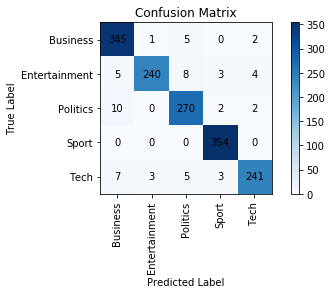

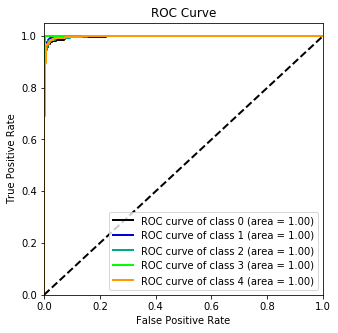

In [45]:
kFold(df_tfidf, MultinomialNB())

#### Naive Bayes with Word Vectors

Accuracy:	 0.9735099337748344
F1 score:	 0.9722177396117407
Fit Time:	 0.20489821434020997
Score Time:	 0.013143372535705567


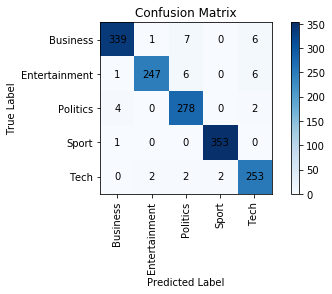

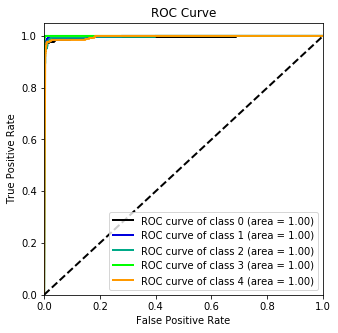

In [46]:
kFold(count_vect_df, MultinomialNB())

#### Naive Bayes with  NMF

Accuracy:	 0.604635761589404
F1 score:	 0.5287371180291816
Fit Time:	 0.002083611488342285
Score Time:	 0.0009417057037353516


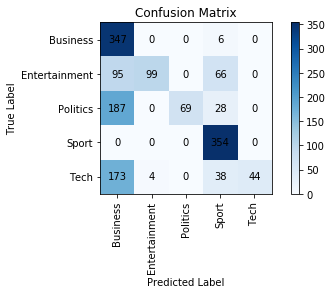

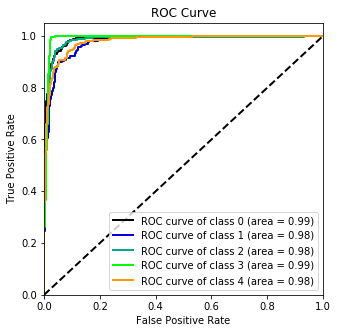

In [47]:
kFold(nmf_df, MultinomialNB())

### Hyperparameter Optimization: Naive Bayes

In [48]:
print('The searching range is: ' + str(np.linspace(0,1,11)))
classifier = MultinomialNB()
parameters = {'alpha': (np.linspace(0.01,1,11))}

gridSearchNB  = GridSearchCV(classifier, parameters, cv=10,scoring='accuracy')
gridSearchNB2  = GridSearchCV(classifier, parameters, cv=10,scoring='accuracy')
gridSearchNB3  = GridSearchCV(classifier, parameters, cv=10,scoring='accuracy')

gridSearchNB_tfidf  = gridSearchNB.fit(df_tfidf, new_trainset['category'])
gridSearchNB_wv  = gridSearchNB2.fit(count_vect_df, new_trainset['category'])
gridSearchNB_nmf  = gridSearchNB3.fit(nmf_df, new_trainset['category'])

NB_tfidf_parameters = gridSearchNB_tfidf.best_params_
NB_wv_parameters = gridSearchNB_wv.best_params_
NB_nmf_parameters = gridSearchNB_nmf.best_params_

print('The best tfidf parameter is: ', NB_tfidf_parameters['alpha'])
print('The best word vector parameter is: ', NB_wv_parameters['alpha'])
print('The best NMF parameter is: ', NB_nmf_parameters['alpha'])

The searching range is: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
The best tfidf parameter is:  0.01
The best word vector parameter is:  0.01
The best NMF parameter is:  0.01


#### Naive Bayes with TF-IDF and Hyperparameter Optimisation

Accuracy:	 0.9741721854304636
F1 score:	 0.9730471710759174
Fit Time:	 0.20187845230102539
Score Time:	 0.008280181884765625


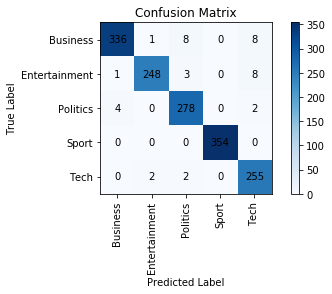

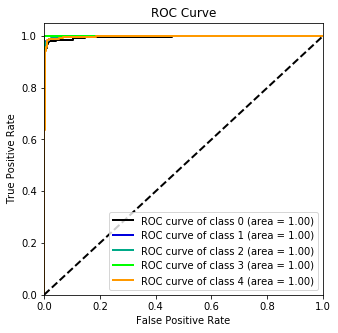

In [49]:
kFold(df_tfidf, MultinomialNB(alpha=NB_tfidf_parameters['alpha']))

#### Naive Bayes with Word Vectorization with Hyperparamater Optimisation

Accuracy:	 0.976158940397351
F1 score:	 0.9751517726429546
Fit Time:	 0.26322762966156005
Score Time:	 0.016765427589416505


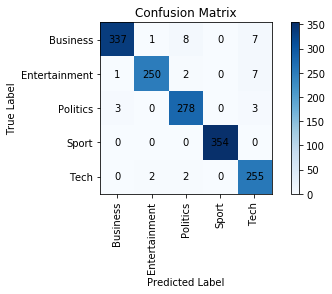

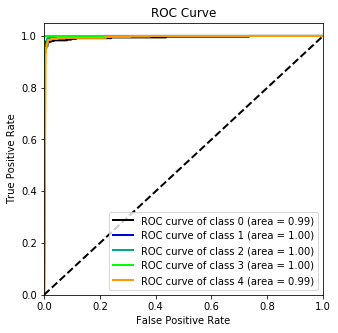

In [50]:
kFold(count_vect_df, MultinomialNB(alpha=NB_wv_parameters['alpha']))

#### Naive Bayes with NMF with Hyperparamater Optimisation


Accuracy:	 0.6304635761589404
F1 score:	 0.571408082247
Fit Time:	 0.003719615936279297
Score Time:	 0.002033376693725586


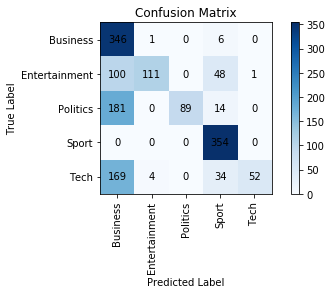

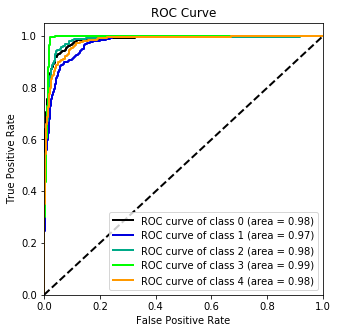

In [51]:
kFold(nmf_df, MultinomialNB(alpha=NB_nmf_parameters['alpha']))

Result: Naive Bayes with Word Vectorization and hyperparameter optimisation has the best accuracy.

## kNN
We have set k = 3 for now. 
Hyperparameter Optimisation will be done with k set to 1, 3 and 5.

#### kNN with TF-IDF

Accuracy:	 0.9139072847682119
F1 score:	 0.9112058215923626
Fit Time:	 0.8299734115600585
Score Time:	 4.857936763763428


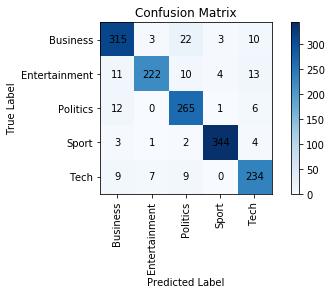

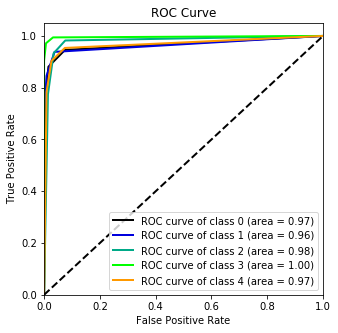

In [52]:
kFold(df_tfidf, KNeighborsClassifier(n_neighbors=3))

#### kNN with Word Vectorizer

Accuracy:	 0.6788079470198676
F1 score:	 0.6780998100901299
Fit Time:	 0.7573543071746827
Score Time:	 4.596831059455871


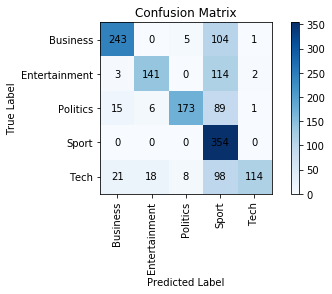

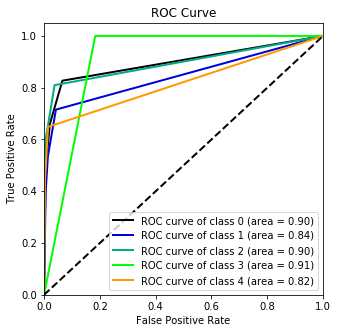

In [53]:
kFold(count_vect_df, KNeighborsClassifier(n_neighbors=3))

#### kNN with NMF

Accuracy:	 0.9390728476821192
F1 score:	 0.9359916854776863
Fit Time:	 0.0015359878540039062
Score Time:	 0.0019392728805541991


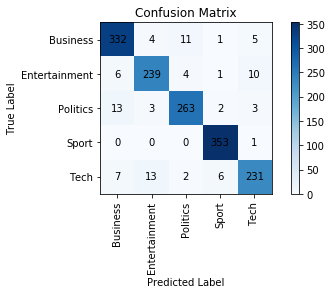

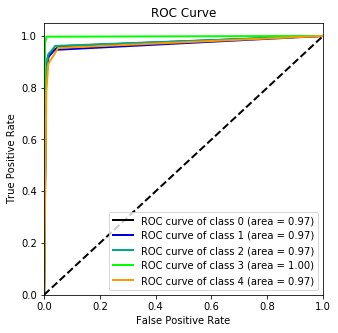

In [54]:
kFold(nmf_df, KNeighborsClassifier(n_neighbors=3))

### Hyperparameter Optimisation: kNN

This code takes up to 20 minutes to run, depite cross validation being set to only 2, and only 3 k values being tested.
This code has been commented out, but the results it produces have been provided below.

In [55]:
# k_range = [1,3,5]
# param_grid = dict(n_neighbors=k_range)
# knn = KNeighborsClassifier()

# grid_tfidf = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
# grid_wv = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
# grid_nmf = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')

# grid_tfidf.fit(df_tfidf, new_trainset['category'])
# grid_wv.fit(count_vect_df, new_trainset['category'])
# grid_nmf.fit(nmf_df, new_trainset['category'])

# grid_tfidf_mean_scores = [result.mean_validation_score for result in grid_tfidf.grid_scores_]
# grid_wv_mean_scores = [result.mean_validation_score for result in grid_wv.grid_scores_]
# grid_nmf_mean_scores = [result.mean_validation_score for result in grid_nmf.grid_scores_]

The code below is to account for the fact the previous cell has been commented out; it is not needed otherwise. These are the scores produced by the hyperparamter optimisation algorithm.

In [56]:
grid_tfidf_mean_scores = [0.8887417218543047, 0.9119205298013245, 0.9264900662251656]
grid_wv_mean_scores = [0.7026490066225165, 0.6079470198675496, 0.5556291390728477]
grid_nmf_mean_scores = [0.9291390728476822, 0.93841059602649, 0.9417218543046357]

#### Results of Optimisation

In [57]:
print(max(grid_tfidf_mean_scores))
print(max(grid_wv_mean_scores))
print(max(grid_nmf_mean_scores))

0.9264900662251656
0.7026490066225165
0.9417218543046357


As we can see, none of the max scores for TF-IDF, Word Vectors, or NMF out-perform the most successful combination so far; Naive Bayes with Word Vectors.

# Part 5: Model Accuracy on Test Data 

We chose our optimized Naive Bayes with tf-idf as it performed the best.

## Load, Clean, and Preprocess Test Data.

Below we load our test data and ensure it is in the expected format.

In [58]:
raw_testset = pd.read_csv('testdata.csv',sep='^',header=0)
raw_testset.head()

,content
0,Eminem secret gig venue revealed Rapper Eminem...
1,Munster Cup tie switched to Spain Munster's He...
2,Eastwood's Baby scoops top Oscars Clint Eastwo...
3,Spears seeks aborted tour payment Singer Britn...
4,Gadget show heralds MP3 Christmas Partners of ...


Now, clean test data in the same way we cleaned the training data.

In [59]:
#make a new test set
new_testset = raw_testset.copy()

#### Tokenization
test_tokensList = [] # this is a list of lists. Each list contains the tokens of a document.

for content in new_testset['content']:
    token_words = tokenizer.tokenize(content) #tokenize all words in the document
    test_tokensList.append(token_words) #add this list to tokensList

#### Cleaning tokens
test_tokensList = clean(test_tokensList) # apply all cleaning

#### Add tokens to dataframe
new_testset['tokens'] = test_tokensList

#### Combine tokens into a string
clean_content_test_tokens = []
for listOfTestTokens in new_testset['tokens']:
    clean_content_test_tokens.append(' '.join(listOfTestTokens))
    
#### Add cleaned content to dataframe
new_testset['test_clean_content'] = clean_content_test_tokens

new_testset.head()

,content,tokens,test_clean_content
0,Eminem secret gig venue revealed Rapper Eminem...,"[eminem, secret, gig, venue, revealed, rapper,...",eminem secret gig venue revealed rapper eminem...
1,Munster Cup tie switched to Spain Munster's He...,"[munster, cup, tie, switched, spain, munster, ...",munster cup tie switched spain munster heineke...
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,"[eastwood, baby, scoop, top, oscar, clint, eas...",eastwood baby scoop top oscar clint eastwood m...
3,Spears seeks aborted tour payment Singer Britn...,"[spear, seek, aborted, tour, payment, singer, ...",spear seek aborted tour payment singer britney...
4,Gadget show heralds MP3 Christmas Partners of ...,"[gadget, show, herald, MP3, christmas, partner...",gadget show herald MP3 christmas partner love ...


## Convert test-data to Word Vec

In [60]:
test_count_vectorizer = CountVectorizer()
test_word_vec = count_vectorizer.transform(new_testset['test_clean_content'])
print(test_word_vec)
#=terms = test_count_vectorizer.get_feature_names()
#test_count_vect_df = pd.DataFrame(test_word_vec.todense(), columns=terms)

  (0, 61)	1
  (0, 114)	2
  (0, 297)	4
  (0, 537)	1
  (0, 538)	1
  (0, 566)	1
  (0, 800)	1
  (0, 1015)	4
  (0, 1089)	1
  (0, 1613)	1
  (0, 1759)	1
  (0, 2151)	2
  (0, 2506)	1
  (0, 2570)	1
  (0, 2571)	1
  (0, 3017)	1
  (0, 3163)	2
  (0, 3195)	1
  (0, 3618)	1
  (0, 3953)	1
  (0, 4029)	5
  (0, 4202)	1
  (0, 4824)	3
  (0, 5063)	1
  (0, 5090)	3
  :	:
  (667, 10511)	1
  (667, 10636)	1
  (667, 10986)	1
  (667, 11015)	1
  (667, 11079)	1
  (667, 11214)	1
  (667, 11378)	1
  (667, 11488)	3
  (667, 11520)	1
  (667, 11653)	1
  (667, 11702)	1
  (667, 11736)	1
  (667, 11888)	1
  (667, 11931)	1
  (667, 11985)	1
  (667, 11999)	1
  (667, 12099)	1
  (667, 12314)	4
  (667, 12502)	4
  (667, 12547)	1
  (667, 12840)	2
  (667, 12846)	1
  (667, 13213)	1
  (667, 13393)	1
  (667, 13533)	1


In [61]:
print(test_word_vec.shape,count_vect_df.shape)

(668, 13635) (1510, 13635)


## Predict for Test Data

In [62]:
modelbayes = MultinomialNB(alpha=NB_wv_parameters['alpha'])
modelbayes.fit(count_vect_df,new_trainset['category']) #fitted to trainset and its categories
predicted_labels_bayes = modelbayes.predict(test_word_vec)

## Results 

In [63]:
final_results = pd.DataFrame() #empty dataframe to combine content and category
final_results_content = [] #empty list to store content
final_results_categories = [] #empty list to store category

_labels = ['business', 'entertainment', 'politics', 'sport', 'tech'] #labels for clarity

# assemble the lists for all the original raw dataset
for i in range(len(raw_testset)):
    final_results_content.append(raw_testset['content'][i])
    final_results_categories.append(_labels[np.int(predicted_labels_bayes[i])])
    
# add lists to final dataframe
final_results['content'] = final_results_content
final_results['predicted_category'] = final_results_categories

#print results
final_results

,content,predicted_category
0,Eminem secret gig venue revealed Rapper Eminem...,entertainment
1,Munster Cup tie switched to Spain Munster's He...,sport
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,entertainment
3,Spears seeks aborted tour payment Singer Britn...,entertainment
4,Gadget show heralds MP3 Christmas Partners of ...,tech
5,US Airways staff agree to pay cut A union repr...,business
6,Blunkett row should end - Blair Prime Minister...,politics
7,Nasdaq planning $100m share sale The owner of ...,business
8,Gallery unveils interactive tree A Christmas t...,entertainment
9,Escaped prisoner report ordered First Minister...,politics


In [64]:
final_results.to_csv("final_results_CessnaSkyhawk.csv", index=False)

## Reload to ensure csv is in correct format

In [65]:
test_results_csv = pd.read_csv("final_results_CessnaSkyhawk.csv")
test_results_csv.head()

,content,predicted_category
0,Eminem secret gig venue revealed Rapper Eminem...,entertainment
1,Munster Cup tie switched to Spain Munster's He...,sport
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,entertainment
3,Spears seeks aborted tour payment Singer Britn...,entertainment
4,Gadget show heralds MP3 Christmas Partners of ...,tech
